## Augmentation을 모델 학습에 적용하기

- augmentation 적용을 통한 학습 효과 확인하기
- 다양한 augmentation 기법 적용해보기

## 1. 데이터 불러오기

tf_datasets 활용

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pickle

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### stanford_dogs

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


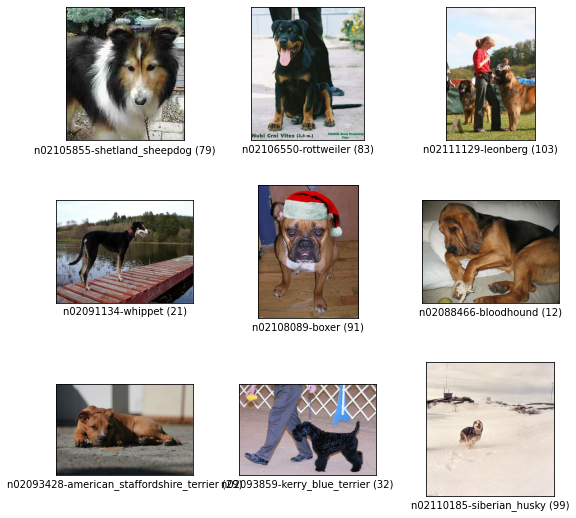

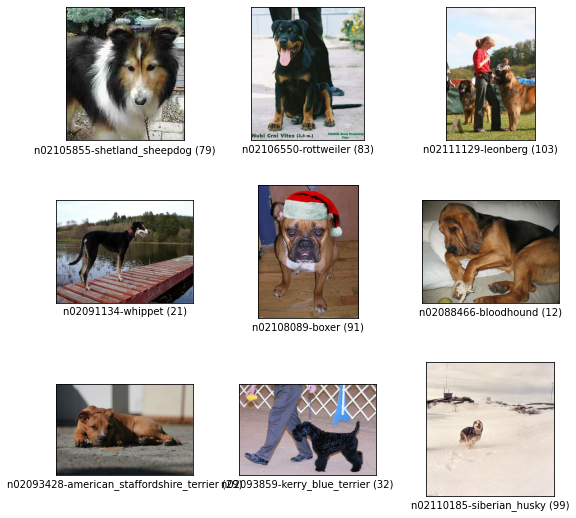

In [4]:
tfds.show_examples(ds_train, ds_info)

___

## 2. Augmentation 함수 

전처리 함수

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

#### random_flip , random_brightness

👉Train data에만 적용

test에도 적용? 여러 결과를 조합하는 **ensemble**과 같은 효과, **TTA**

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1) #min-max 기준 값 지정
    return image, label

In [7]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

#### pre-processing + augmentation

In [8]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

___

## 3. Augmentation 적용하기

#### augmentation에 따른 성능 변화 확인

- imagenet data를 가지고 훈련된 ResNet 모델을 불러와서 사용.

In [9]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, #마지막 fc layer를 불러올 지 여부
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax') #fc layer
])

94773248/94765736 [==============================] - 1s 0us/step


In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

augmentation 적용, 적용 안된 데이터셋 생성

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False) #aug X
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True) #aug o
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

실제 프로젝트 진행 시에는 EPOCHS를 20 정도로 진행한다.

In [12]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [13]:

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('/aiffel/aiffel/history_resnet50_no_aug', 'wb') as file_pi:
    pickle.dump(history_resnet50_no_aug.history, file_pi)

Epoch 1/20
750/750 [==============================] - 357s 441ms/step - loss: 3.2030 - accuracy: 0.2761 - val_loss: 3.2342 - val_accuracy: 0.2185
Epoch 2/20
750/750 [==============================] - 333s 444ms/step - loss: 0.9493 - accuracy: 0.7346 - val_loss: 1.0595 - val_accuracy: 0.6868
Epoch 3/20
750/750 [==============================] - 333s 444ms/step - loss: 0.3285 - accuracy: 0.9238 - val_loss: 0.9169 - val_accuracy: 0.7294
Epoch 4/20
750/750 [==============================] - 333s 444ms/step - loss: 0.0801 - accuracy: 0.9917 - val_loss: 0.9136 - val_accuracy: 0.7339
Epoch 5/20
750/750 [==============================] - 333s 444ms/step - loss: 0.0306 - accuracy: 0.9988 - val_loss: 0.9133 - val_accuracy: 0.7416
Epoch 6/20
750/750 [==============================] - 333s 443ms/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.9211 - val_accuracy: 0.7442
Epoch 7/20
750/750 [==============================] - 332s 443ms/step - loss: 0.0117 - accuracy: 0.9999 - val_loss: 0.9288 -

In [14]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('/aiffel/aiffel/history_resnet50_aug', 'wb') as file_pi:
    pickle.dump(history_resnet50_aug.history, file_pi)

Epoch 1/20
750/750 [==============================] - 339s 445ms/step - loss: 3.2684 - accuracy: 0.2687 - val_loss: 3.1125 - val_accuracy: 0.2367
Epoch 2/20
750/750 [==============================] - 333s 444ms/step - loss: 1.0760 - accuracy: 0.6942 - val_loss: 1.2787 - val_accuracy: 0.6347
Epoch 3/20
750/750 [==============================] - 333s 444ms/step - loss: 0.5877 - accuracy: 0.8397 - val_loss: 1.0557 - val_accuracy: 0.6945
Epoch 4/20
750/750 [==============================] - 333s 444ms/step - loss: 0.3024 - accuracy: 0.9249 - val_loss: 1.0628 - val_accuracy: 0.6897
Epoch 5/20
750/750 [==============================] - 332s 443ms/step - loss: 0.1905 - accuracy: 0.9623 - val_loss: 0.9639 - val_accuracy: 0.7203
Epoch 6/20
750/750 [==============================] - 332s 442ms/step - loss: 0.1004 - accuracy: 0.9833 - val_loss: 1.0005 - val_accuracy: 0.7271
Epoch 7/20
750/750 [==============================] - 333s 444ms/step - loss: 0.0583 - accuracy: 0.9938 - val_loss: 0.9703 -

#### 시각화

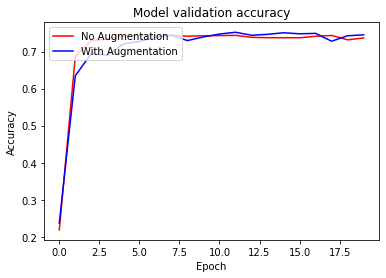

In [15]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

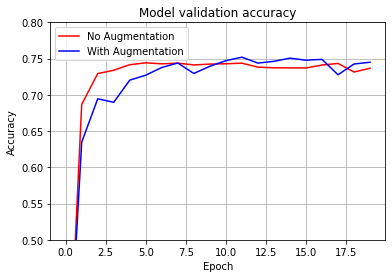

In [16]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

#### 20 EPOCHS 실행 시 결과

- 10 epochs 이후부터 accuracy 개선

![image](https://user-images.githubusercontent.com/86637320/135209411-49ac61ce-1866-4ea1-921c-8e93374c50aa.png)

![image](https://user-images.githubusercontent.com/86637320/135209439-cce9c854-1019-4858-a22f-dcaa4bc3473f.png)


___

## 4. 심화 기법

![image](https://user-images.githubusercontent.com/86637320/135212982-8dc6cccb-9243-4d4e-a824-f748b67f0ab2.png)

- Mixup : 특정 비율로 픽셀별 값을 섞는 방식

- Cutout : 특정 영역의 픽셀을 0으로 만드는 방법

- CutMix : 이미지의 일정 영역을 잘라내 붙이는 방법

### CutMix 기법

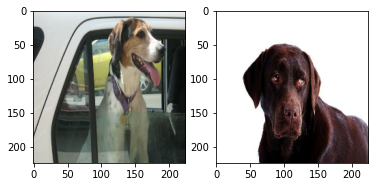

In [17]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)): #ds_train : (16,224,224,3)
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

#### bounding box 위치를 결정

- a 이미지 : 바탕
- b 이미지 : cut

In [18]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(121, shape=(), dtype=int32)
y :  tf.Tensor(134, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


#### 이미지 합치기

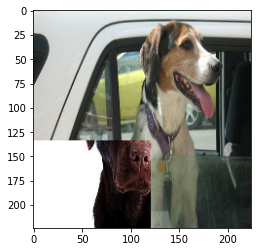

In [19]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

#### 라벨 섞기

In [20]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.782964  , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.21703604, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

#### cutmix 함수

In [21]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

___

### Mixup

![image](https://user-images.githubusercontent.com/86637320/135281676-058a7978-3e7e-4026-89d2-303ac74e949d.png)

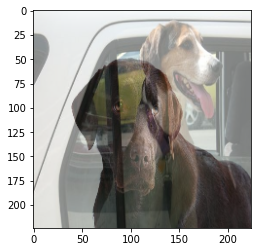

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.52149177 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.47850823 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [22]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [23]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

___

## 5. CutMix, Mixup 비교하기

- CutMix의 경우 Batch 내 이미지만 섞기 때문에 ds.batch 이후에 cutmix 진행!

In [24]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [25]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image,label):
    label = tf.one_hot(label, num_classes)
    return image, label
    
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )  
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [26]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True) #cutmix o
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_mixup=True) #mixup o
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

#### mixup

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.6182649
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.3817351 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0

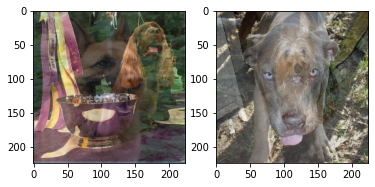

In [27]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_mixup.take(1)): #ds_train : (16,224,224,3)
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

print(label_a, label_b)
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

#### cutmix

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(120,), dtype=float32) tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.5515386 0.        0.        0.        0.        0.4484614 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.   

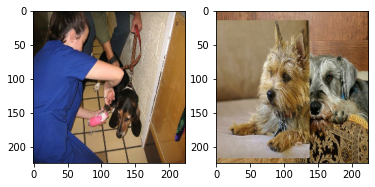

In [28]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_cutmix.take(1)): #ds_train : (16,224,224,3)
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

print(label_a, label_b)
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

#### aug

tf.Tensor(56, shape=(), dtype=int64) tf.Tensor(88, shape=(), dtype=int64)


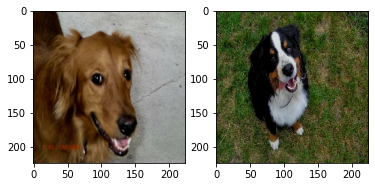

In [29]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_aug.take(1)): #ds_train : (16,224,224,3)
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

print(label_a, label_b)
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

___

#### ResNet 모델을 통해 augmentation 비교

In [30]:
num_classes = ds_info.features["label"].num_classes

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, #마지막 fc layer를 불러올 지 여부
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax') #fc layer
])

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, #마지막 fc layer를 불러올 지 여부
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax') #fc layer
])

#### cutmix, mixup : categorical_crossentropy

In [31]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

cutmix_resnet50.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [32]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('/aiffel/aiffel/history_resnet50_cutmix', 'wb') as file_pi:
    pickle.dump(history_resnet50_cutmix.history, file_pi)

Epoch 1/20
750/750 [==============================] - 343s 449ms/step - loss: 4.3239 - accuracy: 0.1127 - val_loss: 3.3645 - val_accuracy: 0.1994
Epoch 2/20
750/750 [==============================] - 336s 449ms/step - loss: 3.0491 - accuracy: 0.4075 - val_loss: 1.6182 - val_accuracy: 0.5752
Epoch 3/20
750/750 [==============================] - 336s 448ms/step - loss: 2.7056 - accuracy: 0.5144 - val_loss: 1.1815 - val_accuracy: 0.6677
Epoch 4/20
750/750 [==============================] - 336s 448ms/step - loss: 2.4733 - accuracy: 0.5870 - val_loss: 1.1933 - val_accuracy: 0.6708
Epoch 5/20
750/750 [==============================] - 336s 448ms/step - loss: 2.3156 - accuracy: 0.6421 - val_loss: 1.2887 - val_accuracy: 0.6595
Epoch 6/20
750/750 [==============================] - 336s 448ms/step - loss: 2.1501 - accuracy: 0.6884 - val_loss: 1.1428 - val_accuracy: 0.6821
Epoch 7/20
750/750 [==============================] - 336s 448ms/step - loss: 2.0775 - accuracy: 0.7056 - val_loss: 1.1657 -

In [33]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('/aiffel/aiffel/history_resnet50_mixup', 'wb') as file_pi:
    pickle.dump(history_resnet50_mixup.history, file_pi)

Epoch 1/20
750/750 [==============================] - 343s 450ms/step - loss: 4.2583 - accuracy: 0.1344 - val_loss: 4.0995 - val_accuracy: 0.1288
Epoch 2/20
750/750 [==============================] - 336s 448ms/step - loss: 2.9567 - accuracy: 0.4516 - val_loss: 1.8429 - val_accuracy: 0.4971
Epoch 3/20
750/750 [==============================] - 336s 448ms/step - loss: 2.6240 - accuracy: 0.5597 - val_loss: 1.3429 - val_accuracy: 0.6302
Epoch 4/20
750/750 [==============================] - 336s 448ms/step - loss: 2.4241 - accuracy: 0.6403 - val_loss: 1.2738 - val_accuracy: 0.6542
Epoch 5/20
750/750 [==============================] - 336s 449ms/step - loss: 2.2978 - accuracy: 0.7015 - val_loss: 1.4015 - val_accuracy: 0.6139
Epoch 6/20
750/750 [==============================] - 336s 449ms/step - loss: 2.1670 - accuracy: 0.7449 - val_loss: 1.1851 - val_accuracy: 0.6727
Epoch 7/20
750/750 [==============================] - 336s 449ms/step - loss: 2.0622 - accuracy: 0.7696 - val_loss: 1.2451 -

### 시각화

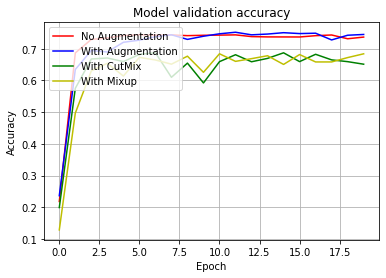

In [37]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With CutMix', 'With Mixup'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

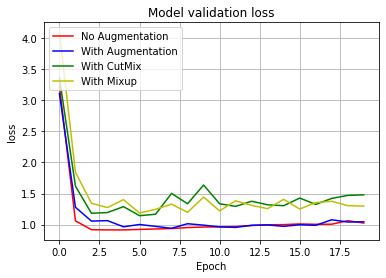

In [36]:
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'y')
plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With CutMix', 'With Mixup'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

In [38]:
with open('/aiffel/aiffel/history_resnet50_mixup2', 'wb') as file_pi:
    pickle.dump(history_resnet50_mixup.history, file_pi)

___

## 정리

다양한 augmentaton 기법을 적용한 데이터셋을 이용해 ResNet을 학습시켜 augmentation 별 효과를 확인할 수 있었다.

기본적인 **augmentation(flipping, brightness 변경)**만 진행했을 경우 가장 좋은 성능을 기록했다.

Cut-mix와 Mix-up 기법의 경우 실험에 사욛된 LR(0.001), Batch-Size(16)에선 좋은 결과를 얻지 못했지만   
**하이퍼 파라미터**를 변경한다면 좋은 결과가 나올 수 있을 것이라고 생각된다.

학습이 오래 걸려서 혹시 몰라서 history 정보를 따로 저장해두었는데 다행히도 쓸 일은 없었다.